In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import davemodel
from davemodel import MyLogisticRegression, DaveModelBase
from importlib import reload


In [2]:
men_train = pd.read_csv("_RawData/mens_train_file.csv")
men_test = pd.read_csv("_RawData/mens_test_file.csv")
women_train = pd.read_csv("_RawData/womens_train_file.csv")
women_test = pd.read_csv("_RawData/womens_test_file.csv")


In [3]:
print(men_train.shape)
print(men_test.shape)
print(women_train.shape)
print(women_test.shape)


(5000, 28)
(2000, 28)
(5000, 28)
(1000, 28)


In [4]:
# Analyse data

men_analyse = pd.DataFrame(columns=["Name", "Type", "Unique", "NA"])

for col in men_train.columns:
    men_data = men_train[col]
    men_analyse = men_analyse.append({
        "Name": col, 
        "Type": men_data.dtype, 
        "Unique": men_data.nunique(), 
        "NA": men_data.isnull().sum()
    }, ignore_index=True)

men_analyse.sort_values(by = "Type")

Name     Type Unique NA
23             server.is.impact.player     bool      2  0
20                           same.side     bool      2  0
7                     outside.sideline     bool      2  0
8                     outside.baseline     bool      2  0
0                                rally    int64     30  0
1                                serve    int64      2  0
25                               train    int64      1  0
24                                  id    int64   5000  0
22                previous.time.to.net  float64   5000  0
19       opponent.distance.from.center  float64   4505  0
18                      opponent.depth  float64   4605  0
17                      previous.depth  float64   5000  0
16     previous.distance.from.sideline  float64   5000  0
15              previous.net.clearance  float64   5000  0
13         player.distance.from.center  float64   4219  0
12                        player.depth  float64   4582  0
11  player.impact.distance.from.center  float64   4447  0
10                 player.impact.depth  float64   4686  0
9            player.distance.travelled  float64   4991  0
6                                depth  float64   5000  0
5               distance.from.sideline  float64   5000  0
4                        net.clearance  float64   4999  0
3                                speed  float64   5000  0
14                      previous.speed  float64   5000  0
26                             outcome   object      3  0
21                   previous.hitpoint   object      4  0
2                             hitpoint   object      4  0
27                              gender   object      1  0

In [438]:
def speed_cat(prev_speed):
    speed = 0
    
    if prev_speed < 20:
        speed = 0
    elif prev_speed < 25:
        speed = 1
    elif prev_speed < 30:
        speed = 2
    elif prev_speed < 35:
        speed = 3
    elif prev_speed < 40:
        speed = 4
    else:
        speed = 5
        
    return speed

def net_clearance(clearance):
    net = 0
    
    if clearance < 0:
        net = 0
    elif clearance < 0.5:
        net = 1
    elif clearance < 1:
        net = 2
    elif clearance < 2:
        net = 3
    else:
        net = 4
        
    return net
        
# Remove unneeded columns
def process_data(data, gender):
    ids = data["id"].apply(lambda x: str(x) + "_" + gender)

    cat_cols = ["server.is.impact.player", "same.side", "outside.baseline", "outside.sideline", "serve", "hitpoint", "previous.hitpoint"]
    cat_cols += ["easy.shot", "net.clearance.group", "prev.speed.group", "speed.group"]
    drop_cols = ["id", "train", "gender", "outcome", "previous.speed", "speed", "net.clearance"]
#                  "previous.speed", "opponent.distance.from.center", "previous.depth", "previous.net.clearance"]
    drop_cols += cat_cols
    num_cols = [x for x in data.columns.tolist() if x not in drop_cols]
#     num_cols += ["prev.speed.group", "speed.group"]
    print(len(cat_cols) + len(drop_cols) + len(num_cols))
    
    new_data = data.copy()
    
    
#         (men_train["outside.sideline"] == False) 
#     & (men_train["outside.baseline"] == False)
#     & (men_train["net.clearance"] > 0)

    new_data["prev.speed.group"] = new_data["previous.speed"].apply(lambda x: speed_cat(x))
    new_data["speed.group"] = new_data["speed"].apply(lambda x: speed_cat(x))
#     new_data["over.net"] = new_data["net.clearance"] > 0
    new_data["net.clearance.group"] = new_data["net.clearance"].apply(lambda x: net_clearance(x))
    
#     new_data["good.shot"] = ((new_data["outside.sideline"] == False)
#                             & (new_data["outside.baseline"] == False)
#                             & (new_data["net.clearance"] > 0))
    
    new_data["easy.shot"] = ((new_data["previous.speed"] < 30)
    & (new_data["opponent.distance.from.center"] > 2)
    & (new_data["previous.depth"] > 3)
    & (new_data["previous.net.clearance"] > 1)
    & (new_data["outside.sideline"] == False) 
    & (new_data["outside.baseline"] == False)
    & (new_data["net.clearance"] > 0))
    #     & (men_train["depth"] > 0.2)
    #     & (men_train["distance.from.sideline"] > 0.2)
    #     & (men_train["player.distance.travelled"] < 4)
    #     & (men_train["player.distance.from.center"] < 1)
    #     & (men_train["hitpoint"] != "F")
    
    
    new_data = pd.get_dummies(new_data, columns = cat_cols)
    
    for col in drop_cols:
        if new_data.columns.contains(col):
            new_data = new_data.drop([col], axis = 1)
            
    new_data[num_cols] = (new_data[num_cols] - new_data[num_cols].mean()) / new_data[num_cols].std()


            
    return ids, new_data

    
def get_train_data(data, gender):
    new_label = data["outcome"]
    ids, new_data = process_data(data, gender)

    return ids, new_data, new_label

men_ids, X_men, y_men = get_train_data(men_train, "mens")
women_ids, X_women, y_women = get_train_data(women_train, "womens")

men_test_ids, X_men_test = process_data(men_test, "mens")
women_test_ids, X_women_test = process_data(women_test, "womens")

print(X_men.shape)
print(y_men.shape)
print(X_women.shape)
print(y_women.shape)
print(X_men_test.shape)
print(X_women_test.shape)


43
43
43
43
(5000, 51)
(5000,)
(5000, 51)
(5000,)
(2000, 51)
(1000, 51)


In [439]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
# X_men[X_men["easy.shot"] == True].shape
X_men.head()

rally  distance.from.sideline     depth  player.distance.travelled  \
0 -0.556070                1.830812  0.693324                  -0.808756   
1 -0.556070                0.987769 -0.617805                  -0.345224   
2  4.538600                1.883527  1.519057                   0.528630   
3  0.784633               -0.775933 -0.388228                  -1.293952   
4 -0.556070               -0.476397  0.286893                  -0.333407   

   player.impact.depth  player.impact.distance.from.center  player.depth  \
0             0.762886                           -0.738909      0.612054   
1             0.300325                            2.056659      0.166630   
2             1.150147                           -0.506976      0.624626   
3             0.619564                           -1.633234      0.387663   
4             1.092496                           -0.245167      0.810355   

   player.distance.from.center  previous.net.clearance  \
0                    -1.042314                0.852426   
1                     0.948868               -0.068022   
2                     0.733424               -0.665135   
3                    -1.247052                0.678488   
4                    -0.963936               -0.995855   

   previous.distance.from.sideline  previous.depth  opponent.depth  \
0                         0.330016       -1.699856       -0.018598   
1                        -1.458892       -0.217178       -0.107019   
2                        -0.948881       -0.663091        0.532636   
3                         1.104211       -1.769436        0.701332   
4                        -0.646018       -0.175435       -0.526469   

   opponent.distance.from.center  previous.time.to.net  \
0                      -0.292499             -0.516968   
1                       1.965721             -0.584499   
2                      -0.601518             -0.767404   
3                      -1.712651              0.671082   
4                      -1.008740             -1.066828   

   server.is.impact.player_False  server.is.impact.player_True  \
0                              1                             0   
1                              1                             0   
2                              0                             1   
3                              0                             1   
4                              1                             0   

   same.side_False  same.side_True  outside.baseline_False  \
0                0               1                       1   
1                1               0                       0   
2                1               0                       1   
3                0               1                       1   
4                1               0                       1   

   outside.baseline_True  outside.sideline_False  outside.sideline_True  \
0                      0                       1                      0   
1                      1                       1                      0   
2                      0                       1                      0   
3                      0                       0                      1   
4                      0                       1                      0   

   serve_1  serve_2  hitpoint_B      ...        hitpoint_U  hitpoint_V  \
0        1        0           1      ...                 0           0   
1        0        1           1      ...                 0           0   
2        1        0           1      ...                 0           0   
3        1        0           0      ...                 0           0   
4        1        0           1      ...                 0           0   

   previous.hitpoint_B  previous.hitpoint_F  previous.hitpoint_U  \
0                    0                    1                    0   
1                    1                    0                    0   
2                    0                    1                    0   
3                    1             

In [310]:
men_train[men_train["net.clearance"] < 0]["outcome"].value_counts()

UE    860
FE    536
W      30
Name: outcome, dtype: int64

In [293]:
men_train["player.impact.distance.from.center"].max()

7.7462

In [294]:
men_train[(men_train["net.clearance"] < -0.04)]

rally  serve hitpoint      speed  net.clearance  distance.from.sideline  \
2        23      1        B  22.316690      -0.254046                3.533166   
15        7      1        U  36.984760      -0.080511                2.604461   
24       16      2        U  27.967935      -0.946992                0.544084   
40        5      1        B  35.989531      -0.144370                1.885000   
46       20      1        F  40.228085      -0.078997                2.338881   
66        8      2        F  12.829595      -0.079062                1.705997   
68        7      1        U  13.724058      -0.947000                1.821819   
70        7      2        B  27.729342      -0.051597                2.731384   
74        4      2        B  31.154247      -0.179589                3.071877   
78        4      1        B  17.698573      -0.873287                3.290548   
83        3      2        F  35.261031      -0.051474                2.060361   
85       12      1        F  30.946459      -0.201249                1.802509   
88        4      1        B  28.121026      -0.436939                1.803360   
91        5      2        F  31.593992      -0.095408                2.732270   
94       11      2        B  27.898523      -0.111009                3.490215   
100       8      1        F  38.429152      -0.061424                2.064510   
106       3      2        B  32.509111      -0.194901                2.506670   
107       3      2        B  32.747898      -0.132190                3.923587   
114       3      1        F  40.202454      -0.312721                2.097418   
117       6      2        B  33.184542      -0.569393                0.451928   
120       8      2        F  34.033002      -0.108444                1.743932   
131       4      2        F  32.020603      -0.102440                3.446230   
133       3      1        F  38.031014      -0.090195                1.704345   
135       8      2        F  22.007930      -0.534841                1.958892   
136       3      1        F  34.321280      -0.421592                2.335857   
137       6      2        B  39.926668      -0.188469                1.119101   
139       6      2        F  35.626248      -0.066733                3.572169   
143       3      1        F  41.359738      -0.243621                0.471813   
154       6      2        B  34.355186      -0.044865                1.857906   
155       4      1        B  13.619383      -0.095549                1.886849   
160       4      1        B  36.297396      -0.045274                1.829161   
162       5      1        F  33.103212      -0.241688                3.181002   
163       4      2        F  21.892962      -0.941069                1.029895   
164       9      1        F  32.142769      -0.150366                3.032546   
184       9      2        B  35.827715      -0.040822                0.019027   
191       3      1        F  31.927735      -0.054834                2.641801   
194       4      2        F  35.725044      -0.153694                2.166049   
203       8      1        F  38.388412      -0.432833                0.713996   
205      11      2        B  37.573701      -0.195320                3.434775   
213       9      1        B  14.989946      -0.342824                3.343480   
220       9      2        B  34.075811      -0.424786                3.703900   
225       5      2        B  34.138406      -0.111595                3.212671   
229       7      1        B  20.543062      -0.112427                1.772370   
231       6      2        U  36.910791      -0.049779                1.492501   
240       4      2        B  22.870328      -0.052458                3.885045   
242      13      2        F  35.200215      -0.120187                2.237417   
246       3      1        F  37.334373      -0.104045                0.928953   
247       4      2        B  29.566341      -0.093782                3.943923   
248       5      1        B  21.19621

In [244]:
men_train["outcome"].value_counts()

UE    2118
W     1684
FE    1198
Name: outcome, dtype: int64

In [67]:
men_train[(men_train["outside.sideline"] == True)]["outcome"].value_counts()

UE    625
FE    337
W       4
Name: outcome, dtype: int64

In [68]:
men_train[(men_train["outside.baseline"] == True)]["outcome"].value_counts()

UE    639
FE    315
W      15
Name: outcome, dtype: int64

In [69]:
men_train[(men_train["outside.sideline"] == True) & (men_train["outside.baseline"] == True)]["outcome"].value_counts()

UE    101
FE     55
W       2
Name: outcome, dtype: int64

In [70]:
men_train.shape

(5000, 28)

In [75]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False)]["outcome"].value_counts()

W     1667
UE     955
FE     601
Name: outcome, dtype: int64

In [77]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0)]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

In [81]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0)]

rally  serve hitpoint      speed  net.clearance  distance.from.sideline  \
4         4      1        B  35.544208       0.116162                0.918725   
7         3      1        F  34.445742       0.387828                0.873202   
9        20      1        F  45.379172       0.265430                1.307053   
17        3      1        F  36.097858       0.440323                1.963690   
18        7      1        F   8.285457       0.116761                2.244445   
19        5      1        F  13.835958       0.842147                0.850342   
22        7      1        B  37.274490       0.302868                0.192149   
25        4      2        V  31.634693       0.005703                3.384268   
28        3      1        F  38.064818       0.116020                0.193613   
29       11      2        F  37.538881       0.713130                1.309572   
31        7      2        U  17.316859       0.391822                0.955120   
32        4      1        B  37.915490       0.571731                1.045053   
34        9      2        F  35.175883       0.043887                0.094705   
37        3      2        F  41.726240       0.506111                0.753737   
39        9      2        F  30.475036       0.411422                0.306178   
45        6      2        F  40.068395       0.473639                0.339671   
48        3      1        F  34.368825       0.218907                0.766736   
49        6      1        B  19.608752       3.928351                1.264432   
51        7      1        F  36.628975       0.259331                2.169861   
52        5      1        F  12.750452       0.155089                1.780797   
53        7      2        F  13.085320       0.112572                1.672228   
55        4      2        F  39.496205       0.383302                0.786982   
57        5      1        F  18.431923       0.043621                1.375926   
59       10      2        U  22.662539       2.939769                2.103878   
60        4      1        B  23.518996       0.214878                1.060592   
63        3      1        F  36.748464       0.125095                0.793807   
65        5      2        U  25.348303       0.676748                0.995929   
80        8      2        F  30.273164       0.754952                0.837130   
86       25      2        B  23.764171       1.016154                1.397547   
87        4      1        B  36.612369       0.112160                1.430395   
92        3      1        F  36.758574       0.479986                1.378024   
93        9      2        B  28.012211       0.290075                0.414545   
96        4      1        F  37.891497       0.552750                0.791717   
98        4      1        F  37.263611       0.911257                0.466700   
101       5      1        F  29.358485       0.371608                1.105750   
102       7      2        B  37.166938       0.146934                0.122934   
105       3      1        F  37.439226       0.465858                1.488199   
108       5      1        F  39.528377       0.261162                0.255648   
109      11      2        F  39.565406       0.167123                0.695225   
111       3      1        F  32.814224       0.636794                0.295424   
112       3      1        F  33.777235       0.300023                0.601320   
118       4      1        B  35.193247       0.275119                0.927023   
119       4      1        V  29.924235       0.680200                1.688814   
121       6      1        F  21.775312       3.822812                2.425573   
122      10      2        F  32.030442       1.040858                1.141819   
123       4      2        F  39.028997       0.187494                0.886414   
126       4      2        V  41.930299       0.008306                2.831440   
128       6      1        F  37.996658       0.400656                0.302757   
129       5      2        F  33.85277

In [80]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0) & (men_train["outcome"] != "W")]

rally  serve hitpoint      speed  net.clearance  distance.from.sideline  \
32        4      1        B  37.915490       0.571731                1.045053   
59       10      2        U  22.662539       2.939769                2.103878   
196       5      1        B  31.866835       0.611321                1.029082   
197       8      2        F  32.662894       1.438695                2.199168   
211      10      2        B  23.782676       3.683419                0.980408   
224      21      1        F  26.403233       3.937917                1.663276   
300      12      1        B  31.402052       0.412137                0.022811   
324       6      1        F  33.157324       2.533201                3.490387   
336       4      1        F  31.619901       1.036311                2.336204   
359      14      1        F  42.239182       1.310095                1.810715   
369       9      2        U  38.856053       1.061772                2.473172   
396      10      2        U  22.178520       2.297053                1.521657   
408       3      1        F  28.089287       0.678128                1.043403   
421       4      1        V  23.853017       0.647912                3.420808   
432       3      1        B  39.285138       0.630531                0.578485   
448       3      1        F  25.870527       0.616974                2.376700   
471       5      2        F  40.542860       0.975952                1.467361   
479      10      1        U  17.040686       0.002757                3.873410   
496       3      2        F  28.380168       1.015957                0.048177   
499       5      1        U  22.821797       0.861694                0.106543   
500       3      2        F  33.575830       0.220545                2.071416   
512       9      1        F  42.245138       0.315967                0.037885   
529       5      2        V  22.420413       4.120281                0.231593   
537       3      1        F  32.581922       2.782156                0.280460   
547       4      1        F  29.130377       3.093374                1.800191   
562      13      1        V  10.031523       0.748527                1.660051   
583       3      1        F  29.801498       4.512553                0.638672   
598      10      1        B  20.989838       4.885050                1.206946   
618       5      1        V  28.824172       0.007785                1.058569   
638       3      2        F  15.596487       0.244046                2.084975   
664       6      2        F  34.725581       2.071342                2.655980   
666       7      1        U  17.348718       2.647835                2.823836   
670      11      1        V  25.567052       3.397412                0.701653   
671       3      1        B  36.776722       0.826053                0.933150   
677       5      2        F  22.172592       3.325418                1.107670   
687       4      2        F  19.148737       3.525948                0.562103   
691       3      1        F  31.170178       0.877724                1.451790   
722       6      1        V  24.727051       1.782592                2.449658   
724       6      1        U  31.463602       3.880098                2.045835   
821       3      2        F  36.317930       0.537221                1.352043   
826       9      1        F  26.367091       2.259984                1.306334   
862       4      1        F  38.183859       0.396180                3.279551   
866       3      1        B  28.045042       0.581768                2.356792   
868       3      2        B  34.129303       0.486553                2.209559   
869       3      2        B  33.602200       0.501064                1.610158   
870       3      1        B  35.405109       0.635442                0.540893   
871       3      1        B  34.585714       0.534747                2.154765   
874       3      2        B  25.705143       1.094050                3.413181   
880       3      1        F  33.47419

In [96]:
men_train[
    (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False) 
    & (men_train["net.clearance"] > 0)
#     & ((men_train["distance.from.sideline"] < 0.02) == False)
#     & ((men_train["depth"] < 0.02) == False)
]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

In [99]:
men_train[
    men_train["hitpoint"] == "U"
]["outcome"].value_counts()

W     139
FE    106
UE    104
Name: outcome, dtype: int64

In [ ]:
# Potential features
# Good shot
# Bad shot
# Easy shot
# Hard shot

In [252]:
men_train[
    (men_train["previous.speed"] < 30)
    & (men_train["opponent.distance.from.center"] > 2)
    & (men_train["previous.depth"] > 3)
    & (men_train["previous.net.clearance"] > 1)
    & (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False)
    & (men_train["net.clearance"] > 0)
#     & (men_train["depth"] > 0.2)
#     & (men_train["distance.from.sideline"] > 0.2)
#     & (men_train["player.distance.travelled"] < 4)
#     & (men_train["player.distance.from.center"] < 1)
#     & (men_train["hitpoint"] != "F")
]["outcome"].value_counts()

W     364
UE      3
Name: outcome, dtype: int64

In [307]:
men_train[
    (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False)
    & (men_train["net.clearance"] > 0)
#     & (men_train["depth"] > 0.2)
#     & (men_train["distance.from.sideline"] > 0.2)
#     & (men_train["player.distance.travelled"] < 4)
#     & (men_train["player.distance.from.center"] < 1)
#     & (men_train["hitpoint"] != "F")
]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

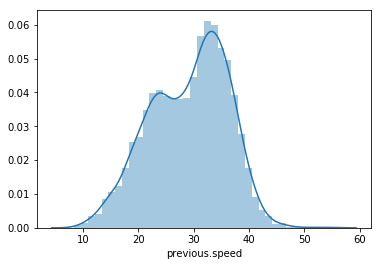

In [220]:
import seaborn as sns
%matplotlib inline
sns.distplot(men_train["previous.speed"])
# men_train["previous.speed"] < 30
# sns.regplot(men_train["previous.speed"], men_train["outcome"])

In [225]:
men_train[(men_train["previous.speed"] < 25) & (men_train["outcome"] == "UE")]

rally  serve hitpoint      speed  net.clearance  distance.from.sideline  \
21        3      1        F  31.691768       0.850041                0.834552   
35        4      2        F  34.960989       0.694679                0.157490   
61        6      1        F  36.737534       0.923519                0.380344   
75       11      2        B  11.191969       1.053560                0.609758   
95        6      2        U  31.373078       0.869382                0.132993   
103       5      1        F  39.904950       0.821090                1.565063   
106       3      2        B  32.509111      -0.194901                2.506670   
107       3      2        B  32.747898      -0.132190                3.923587   
114       3      1        F  40.202454      -0.312721                2.097418   
124       3      1        B  34.659690       0.726126                0.801087   
127       9      1        F  33.610844       0.910466                0.150714   
133       3      1        F  38.031014      -0.090195                1.704345   
136       3      1        F  34.321280      -0.421592                2.335857   
143       3      1        F  41.359738      -0.243621                0.471813   
194       4      2        F  35.725044      -0.153694                2.166049   
201       8      1        F  42.093303       0.959776                0.942683   
233       4      2        B  23.337732       0.617250                0.214740   
236       3      1        F  35.968602       0.442286                0.292768   
238       8      2        F  39.357204       0.574155                0.523209   
245       5      1        B  26.645012       0.688044                0.788288   
246       3      1        F  37.334373      -0.104045                0.928953   
248       5      1        B  21.196215      -0.043484                1.161891   
250       5      1        F  37.904440       0.951518                0.546154   
260       6      1        B  32.325094       0.353998                0.241620   
295       7      1        B  27.661690      -0.093100                2.322729   
309       3      1        F  32.895945       0.798070                0.015642   
321       3      1        F  37.041349      -0.087989                1.364975   
324       6      1        F  33.157324       2.533201                3.490387   
356       3      1        F  41.624438       0.773343                1.185968   
362       3      1        F  34.853353       0.473507                0.584147   
402       7      1        B  27.768978      -0.312307                1.083069   
437       3      1        F  31.108369       0.656486                0.432033   
457       3      2        F  39.058714      -0.004759                1.960348   
503       3      1        B  32.569502       0.442876                0.092385   
504       8      1        B  39.861709       0.932573                1.278085   
508       3      1        F  36.701962       0.744420                0.385133   
515       3      1        F  33.527457       1.105046                1.523378   
540       5      2        B  40.548084       0.750646                0.482078   
542       3      1        U  42.360215       0.806655                0.292872   
564       3      1        B  22.178414       1.198688                0.771092   
566       9      2        U  31.248302      -0.106895                0.687225   
567       3      1        F  31.391986       1.345513                2.342618   
569       3      1        B  25.440387      -0.179041                2.584277   
582       4      2        F  31.595623       0.459528                0.806639   
599       6      2        B  34.147351       0.830235                1.583695   
611      13      1        F  21.369680      -0.138124                1.551101   
630       3      2        U  39.641648      -0.017405                1.433611   
651       3      1        B  19.581795      -0.685607                3.362503   
655       3      1        F  38.11381

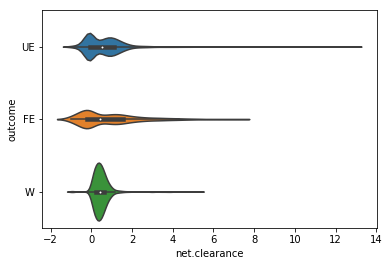

In [416]:
sns.violinplot(men_train["net.clearance"], men_train["outcome"])

In [322]:
men_train[(men_train["rally"] < 4) & (men_train["server.is.impact.player"] == True)]["outcome"].value_counts()

UE    589
W     549
FE    181
Name: outcome, dtype: int64

In [380]:
men_train[
    (men_train["previous.speed"] > 35)
    & ((men_train["previous.depth"] < 1)
    | (men_train["previous.distance.from.sideline"] < 1))
    & (men_train["previous.net.clearance"] < 1)
    & (men_train["player.distance.travelled"] > 3)
]["outcome"].value_counts()

FE    125
UE     18
W      13
Name: outcome, dtype: int64

In [440]:
reload(davemodel)
from davemodel import MyLogisticRegression, MyRandomForest, MyXGBoost, MyBagging, MyGradientBoosting


In [441]:
xgb = MyXGBoost(men_test_ids, X_men, y_men, X_men_test, women_test_ids, X_women, y_women, X_women_test)

In [442]:
xgb.run()


Training men...
Log loss: 0.0655140158704

Training women...
Log loss: 0.0717281517376

Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)
Creating submission...
Done!
Saved


In [443]:
xgb.evaluate()

Log loss: 0.347882771873
Log loss: 0.322999404865


In [446]:
pred_men, pred_women = xgb.predict()


Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)


In [447]:
xgb.create_submission(pred_men, pred_women)

Creating submission...
Done!


In [299]:
forest = MyRandomForest(men_test_ids, X_men, y_men, X_men_test, women_test_ids, X_women, y_women, X_women_test)

In [300]:
forest.run()


Training men...
Log loss: 0.113053191619

Training women...
Log loss: 0.115107020642

Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)
Creating submission...
Done!
Saved


In [301]:
# forest.evaluate
forest.model_men.best_params_

{'max_depth': 13, 'max_features': 10, 'n_estimators': 60}

In [302]:
forest.model_women.best_params_

{'max_depth': 13, 'max_features': 20, 'n_estimators': 60}

In [303]:
forest.evaluate()

Log loss: 0.381428495174
Log loss: 0.357969562564
